<a href="https://colab.research.google.com/github/Getting-into-coding/Google-Colab-CNN-Training-Notebooks/blob/main/Densenet_121_Rice_Disease_Model_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check GPU - AT MINIMUM NEEDS TO BE TESLA T4**

In [8]:
!nvidia-smi

Sun Feb 23 11:53:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |    4212MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **JS code to keep colab connected:**

**Code Below is for the web console to reduce chance of being disconnected:**



```
# This is formatted as code
```
var keepAliveIntervalId;

function startKeepColabAlive() {
  keepAliveIntervalId = setInterval(function() {
    console.log("Keeping Colab alive...");
  }, 30000);
  console.log("KeepColabAlive started. To stop it, call stopKeepColabAlive().");
}

function stopKeepColabAlive() {
  clearInterval(keepAliveIntervalId);
  console.log("KeepColabAlive stopped.");
}

startKeepColabAlive();


# **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Preprocessing and Data Augmentation**

In [9]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Define paths to your dataset directory in Google Drive
train_data_dir = '/content/drive/MyDrive/Rice_Leaf_Disease_Kaggle_Datasets/train'

# Create an ImageDataGenerator with augmentation and a validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    validation_split=0.2  # Reserve 20% of data for validation
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 5435 images belonging to 4 classes.
Found 1356 images belonging to 4 classes.


# **Densenet-121 Architecture Model**

In [10]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load the DenseNet121 model with ImageNet weights, excluding the top classification layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Regularization to prevent overfitting
predictions = Dense(4, activation='softmax')(x)  # 4 classes: Bacterialblight, Brownspot, Healthy, LeafBlast

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## **Compile Model and Top Layer**

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Compile the model with the base model frozen
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define the checkpoint path (ensure the folder exists in your Google Drive)
checkpoint_path = '/content/drive/MyDrive/checkpoints/model_epoch_{epoch:02d}.h5'

# Create the ModelCheckpoint callback to save the model at the end of every epoch
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                        save_weights_only=False,
                                        save_freq='epoch',
                                        verbose=1)

# Define callbacks for early stopping and learning rate reduction, along with checkpointing
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    checkpoint_callback
]


In [ ]:
# Train the model for an initial number of epochs (e.g., 20)
initial_epochs = 15
history_initial = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 2587s 15s/step - accuracy: 0.4707 - loss: 1.1989 - val_accuracy: 0.7928 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 2/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7519 - loss: 0.5742 - val_accuracy: 0.7906 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 3/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8047 - loss: 0.4692 - val_accuracy: 0.7972 - val_loss: 0.4475 - learning_rate: 0.0010
Epoch 4/15
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8021 - loss: 0.4647

# **Fine-Tune Training Model**

In [ ]:
# Unfreeze the entire base model for fine-tuning
base_model.trainable = True

# Optionally, freeze the initial layers to retain low-level features
fine_tune_at = 100  # Adjust this index based on your model analysis
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set the number of fine-tuning epochs and calculate the total epochs
fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

# Continue training with the existing callbacks_list (which includes checkpointing)
history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1],
    validation_data=validation_generator,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 1736s 10s/step - accuracy: 0.4961 - loss: 1.1595 - val_accuracy: 0.7957 - val_loss: 0.4934
Epoch 2/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.7583 - loss: 0.5557 - val_accuracy: 0.8304 - val_loss: 0.4191
Epoch 3/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.8120 - loss: 0.4500 - val_accuracy: 0.8333 - val_loss: 0.4017
Epoch 4/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.8220 - loss: 0.4257 - val_accuracy: 0.7898 - val_loss: 0.4504
Epoch 5/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8348 - loss: 0.3847 - val_accuracy: 0.8112 - val_loss: 0.4031
Epoch 6/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.8193 - loss: 0.4169 - val_accuracy: 0.8444 - val_loss: 0.3611
Epoch 7/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.8344 - loss: 0.3865 - val_accuracy: 0.8540 - val_loss: 0.3413
Epoch 8/50
170/170 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8425 - loss: 0.3725 - val_ac

# **Evaluation**

NameError: name 'history_fine' is not defined

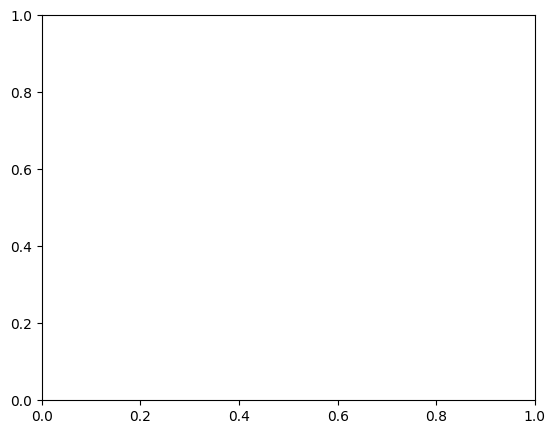

In [2]:
# Plot Training History: Accuracy and Loss over Epochs
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], marker='o', label='Train Loss')
plt.plot(history_fine.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Generate Predictions on Validation Data
validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# Generate and Visualize Confusion Matrix using Seaborn
cm = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict on validation data
validation_generator.reset()
preds = model.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)
y_true = validation_generator.classes

# Generate classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))
print(confusion_matrix(y_true, y_pred))

43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 972ms/step
                 precision    recall  f1-score   support

Bacterialblight       0.22      0.23      0.22       316
      Brownspot       0.21      0.22      0.22       300
        Healthy       0.22      0.10      0.14       297
      LeafBlast       0.32      0.41      0.36       443

       accuracy                           0.26      1356
      macro avg       0.24      0.24      0.23      1356
   weighted avg       0.25      0.26      0.25      1356

[[ 74  78  37 127]
 [ 73  67  24 136]
 [ 75  70  29 123]
 [122  98  42 181]]


# **Testing Model via Image Upload**

Saving bacterial blight.jpg to bacterial blight.jpg


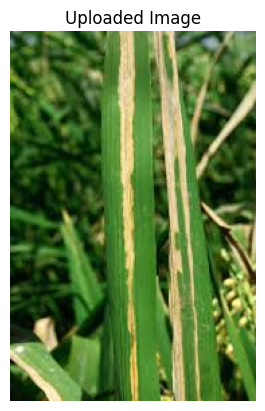

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Predicted Class: Bacterialblight
Prediction Probabilities: [[9.9284053e-01 2.3604043e-04 5.7282520e-08 6.9234441e-03]]


In [ ]:
# ----- Testing the Model with an Uploaded Image -----

# Import necessary modules for file upload, image processing, and visualization.
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Upload an image file from your local machine.
uploaded = files.upload()

# Step 2: Process the uploaded image.
# (Assumes you upload one image at a time.)
for fn in uploaded.keys():
    # Open the image and ensure it's in RGB mode.
    image = Image.open(fn).convert('RGB')

    # Display the original uploaded image.
    plt.imshow(image)
    plt.title("Uploaded Image")
    plt.axis('off')
    plt.show()

    # Resize the image to match the input size expected by the model (224x224).
    image_resized = image.resize((224, 224))

    # Convert the resized image to a numpy array and normalize pixel values.
    img_array = np.array(image_resized) / 255.0

    # Expand dimensions to add a batch axis (model expects a batch of images).
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Make predictions using the trained model.
    predictions = model.predict(img_array)

    # Convert prediction probabilities to a predicted class index.
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Define class names (ensure these match the folders or your generator's class indices).
    # For example, if you used 'flow_from_directory', the class names are the folder names.
    class_names = list(train_generator.class_indices.keys())

    # Retrieve the class name for the highest prediction probability.
    predicted_class = class_names[predicted_class_index]

    # Display the prediction results.
    print("Predicted Class:", predicted_class)
    print("Prediction Probabilities:", predictions)


# **Save and Convert Model as TFLite**

In [ ]:
import pickle

# Define the path where you want to save the training history
history_path = '/content/drive/MyDrive/Rice_Leaf_Disease_Kaggle_Datasets/kaggle_v.2_training_history.pkl'

# Save the history dictionary (from model.fit(...)) to a file
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved to:", history_path)

# Save the original Keras model to Google Drive
model_save_path = '/content/drive/MyDrive/Rice_Leaf_Disease_Kaggle_Datasets/kaggle_v.2_rice_disease_model.h5'
model.save(model_save_path)
print("Keras model saved at:", model_save_path)

# Convert the saved Keras model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to Google Drive
tflite_save_path = '/content/drive/MyDrive/Rice_Leaf_Disease_Kaggle_Datasets/kaggle_v.2_rice_disease_model.tflite'
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved at:", tflite_save_path)

Keras model saved at: /content/drive/MyDrive/kaggle_v.1_rice_disease_model.h5
Saved artifact at '/tmp/tmphtu58pa5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135843835771600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831286864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831284944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831285520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831285904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831284560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843835770256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843831287056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135843

# **-Optional-   Import of Existing model from Gdrive**

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import pickle

# Define the path to your saved training history
history_path = '/content/drive/MyDrive/training_history.pkl'

# Load the training history
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)

print("Training history loaded.")

# Define the path to your saved H5 model on Google Drive
h5_model_path = '/content/drive/MyDrive/Rice_Leaf_Disease_Kaggle_Datasets/kaggle_v.1_rice_disease_model.h5'

# Load the model
loaded_model = load_model(h5_model_path)
print("H5 model loaded from:", h5_model_path)

# Evaluate the model on the validation data
eval_loss, eval_accuracy = loaded_model.evaluate(validation_generator)
print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {eval_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


H5 model loaded from: /content/drive/MyDrive/Rice_Leaf_Disease_Kaggle_Datasets/kaggle_v.1_rice_disease_model.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 844s 19s/step - accuracy: 0.8339 - loss: 0.3401
Validation Loss: 0.3343, Validation Accuracy: 0.8400


No training history available for the loaded model.
43/43 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step


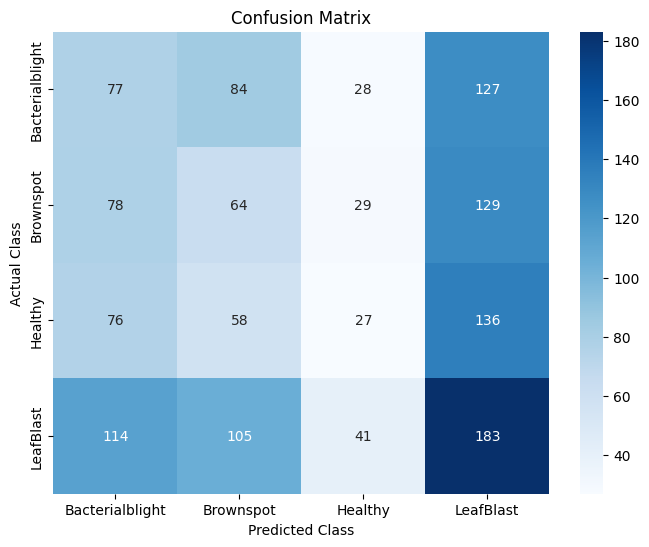

Classification Report:
                  precision    recall  f1-score   support

Bacterialblight       0.22      0.24      0.23       316
      Brownspot       0.21      0.21      0.21       300
        Healthy       0.22      0.09      0.13       297
      LeafBlast       0.32      0.41      0.36       443

       accuracy                           0.26      1356
      macro avg       0.24      0.24      0.23      1356
   weighted avg       0.25      0.26      0.25      1356



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# -------------------------------
# Optional: Plot Training History (if available)
# -------------------------------
if 'history_loaded' in globals():
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_loaded.history['accuracy'], marker='o', label='Train Accuracy')
    plt.plot(history_loaded.history['val_accuracy'], marker='o', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_loaded.history['loss'], marker='o', label='Train Loss')
    plt.plot(history_loaded.history['val_loss'], marker='o', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No training history available for the loaded model.")

# -------------------------------
# Generate Predictions on Validation Data using loaded_model
# -------------------------------
validation_generator.reset()
predictions = loaded_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# -------------------------------
# Generate and Visualize Confusion Matrix using Seaborn
# -------------------------------
cm = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

# -------------------------------
# Print Classification Report
# -------------------------------
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)
